# Hệ thống Nhận diện Chi Nấm và Cảnh báo Độc tính

## Mục tiêu dự án

Notebook này thực hiện **Phase 2 (Fine-tuning với 11 classes)** của hệ thống nhận diện chi nấm với các mục tiêu sau:

- **Nhận diện 11 chi nấm** từ Source Domain (9 classes) và Target Domain (2 classes: Exidia, Inocybe)
- **Tự động cảnh báo độc tính** dựa trên chi nấm được nhận diện (Poisonous/Edible)
- **Sử dụng Transfer Learning** với MobileNet_V3_Large (pre-trained trên ImageNet)
- **Xử lý mất cân bằng dữ liệu** với class weights (Cost-Sensitive Learning):
  - **Class Weights**: Nhân đôi trọng số cho các chi nấm độc để tăng recall
  - **CrossEntropyLoss**: Sử dụng CrossEntropyLoss với class weights (giống backup notebook - đạt 91.37%)
  - **Data Augmentation**: Torchvision transforms đơn giản (Resize, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter)

## Cấu trúc Notebook

1. **Setup & Import**: Cài đặt môi trường, import libraries (bao gồm Albumentations), cấu hình device (CPU) và random seed
2. **Configuration**: Định nghĩa đường dẫn dữ liệu, danh sách classes (11 classes cho Phase 2), toxicity mapping, và hyperparameters
3. **Data Loading**: Load đường dẫn ảnh và labels từ cả Source Domain (9 classes) và Target Domain (2 classes)
4. **Data Exploration**: Phân tích và visualize dataset - thống kê số lượng mẫu, phân phối classes, phân phối độc tính
5. **Data Preprocessing & Augmentation**: 
   - Tạo Custom Dataset class hỗ trợ cả Albumentations và torchvision transforms
   - **Data Augmentation (Torchvision)**: Resize, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter (giống backup)
   - **Transform cho validation/test**: Resize (224x224), ToTensor, Normalize (theo ImageNet standards)
   - Split dataset thành train/val/test (70/15/15) với stratified sampling
   - Tạo DataLoaders với shuffle=True cho training (giống backup)
6. **Model Architecture**: Xây dựng model với Transfer Learning - hỗ trợ 3 backbone: **EfficientNet-B0, ResNet-50, MobileNetV3-Large** (pre-trained trên ImageNet), custom classifier head với Dropout 0.5/0.3 (Dropout → Linear(960→512) → ReLU → Dropout → Linear(512→11))
7. **Loss Function & Optimizer**: 
   - Tính class weights (cost-sensitive learning, nhân đôi cho nấm độc, normalize đúng)
   - **CrossEntropyLoss**: Sử dụng CrossEntropyLoss với class weights (giống backup - đạt 91.37%)
   - Adam optimizer (weight_decay=1e-4), ReduceLROnPlateau scheduler, Early Stopping (patience=5)
8. **Training**: Training pipeline với monitoring - train/validate mỗi epoch, lưu best model, tracking loss và accuracy
9. **Evaluation**: Đánh giá model trên test set - accuracy, classification report (precision, recall, F1-score), confusion matrix, per-class accuracy
10. **Inference Demo**: Test model trên ảnh mẫu từ test set, hiển thị predictions với cảnh báo độc tính
11. **Toxicity Summary**: Tổng kết hệ thống phân loại độc tính và accuracy
12. **Tổng kết**: Đánh giá toàn diện kết quả Phase 2 với phân tích chi tiết



## Bước 1: Setup & Import Libraries

Import tất cả các thư viện cần thiết và cấu hình môi trường.


In [ ]:
# Import các thư viện cơ bản
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Import thư viện xử lý dữ liệu
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Import thư viện Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import MobileNet_V3_Large_Weights
import torch.nn.functional as F

# Import thư viện xử lý ảnh
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Import thư viện đánh giá
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import multiprocessing

# Albumentations (heavy augmentation)
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS_AVAILABLE = True
    print("✓ Albumentations đã được import")
except ImportError:
    ALBUMENTATIONS_AVAILABLE = False
    A = None
    ToTensorV2 = None
    print("⚠ Albumentations chưa được cài đặt. Fallback về torchvision transforms")



# Cấu hình style cho matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Thiết lập random seed để đảm bảo kết quả có thể tái lập
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Cấu hình device: Force sử dụng CPU (không dùng GPU)
device = torch.device("cpu")

# Tối ưu hóa PyTorch cho CPU: sử dụng tất cả CPU cores có sẵn
num_cpu_cores = multiprocessing.cpu_count()
torch.set_num_threads(num_cpu_cores)
print(f"Setup hoàn tất!")
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Số CPU cores: {num_cpu_cores}")
print(f"PyTorch sẽ sử dụng {torch.get_num_threads()} threads")



Setup hoàn tất!
Device: cpu
PyTorch version: 2.9.1+cu128
Số CPU cores: 12
PyTorch sẽ sử dụng 12 threads


## Bước 2: Cấu hình Đường dẫn và Tham số

Định nghĩa các đường dẫn dữ liệu, class labels, và hyperparameters.


In [ ]:
# ==================== ĐƯỜNG DẪN DỮ LIỆU ====================
# Định nghĩa đường dẫn thư mục gốc và các thư mục dữ liệu
BASE_DIR = Path.cwd()
SOURCE_DATA_DIR = Path("/home/nam/mushroom_data/archive/Mushrooms")
TARGET_DATA_DIR = Path("/home/nam/mushroom_data/archive/Transfer data/Transfer data")

# Tạo các thư mục để lưu kết quả (models và results)
MODELS_DIR = BASE_DIR / "models"
RESULTS_DIR = BASE_DIR / "results"
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

# ==================== CLASS LABELS ====================
# Định nghĩa các class labels cho Source Domain (9 chi nấm)
SOURCE_CLASSES = [
    "Agaricus",
    "Amanita", 
    "Boletus",
    "Cortinarius",
    "Entoloma",
    "Hygrocybe",
    "Lactarius",
    "Russula",
    "Suillus"
]

# Định nghĩa các class labels cho Target Domain (2 chi nấm)
TARGET_CLASSES = [
    "Exidia",
    "Inocybe"
]

# ==================== PHASE 2: FINE-TUNING (11 CLASSES) ====================
# PHASE 2: Sử dụng cả Source Domain (9 classes) và Target Domain (2 classes: Exidia, Inocybe)
ALL_CLASSES = SOURCE_CLASSES + TARGET_CLASSES  # 11 classes: 9 Source + 2 Target
NUM_CLASSES = len(ALL_CLASSES)  # Phải bằng 11

# Tạo mapping từ tên class sang index và ngược lại (cho 11 lớp)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(ALL_CLASSES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

print("="*70)
print("PHASE 2: FINE-TUNING - 11 CLASSES (SOURCE + TARGET DOMAIN)")
print("="*70)
print(f"Đã load {NUM_CLASSES} classes:")
for i, cls in enumerate(ALL_CLASSES):
    domain = "Source" if cls in SOURCE_CLASSES else "Target"
    print(f"  {i+1:2d}. {cls:<15} ({domain})")
print("="*70)

# ==================== TOXICITY MAPPING ====================
# Mapping độc tính cho từng chi nấm
# P = Poisonous (Độc), E = Edible (Ăn được)
TOXICITY_MAPPING = {
    # Poisonous (P) - Chi nấm độc
    "Amanita": "P",
    "Cortinarius": "P",
    "Entoloma": "P",
    "Inocybe": "P",
    # Edible (E) - Chi nấm ăn được
    "Agaricus": "E",
    "Boletus": "E",
    "Hygrocybe": "E",
    "Lactarius": "E",
    "Russula": "E",
    "Suillus": "E",
    "Exidia": "E"
}

# Tách các chi nấm độc và ăn được
POISONOUS_CLASSES = [cls for cls, tox in TOXICITY_MAPPING.items() if tox == "P"]
EDIBLE_CLASSES = [cls for cls, tox in TOXICITY_MAPPING.items() if tox == "E"]

print(f"\nChi nấm ĐỘC ({len(POISONOUS_CLASSES)}): {', '.join(POISONOUS_CLASSES)}")
print(f"Chi nấm ĂN ĐƯỢC ({len(EDIBLE_CLASSES)}): {', '.join(EDIBLE_CLASSES)}")

# ==================== HYPERPARAMETERS ====================
# Cấu hình training: tối ưu cho CPU
# num_workers: sử dụng số CPU cores có sẵn để load data song song
# batch_size: có thể điều chỉnh tùy theo RAM của máy
TRAIN_CONFIG = {
    "batch_size": 16,  # Giảm batch size để phù hợp với CPU
    "num_epochs": 50,
    "learning_rate": 0.001,
    "image_size": (224, 224),
    "num_workers": num_cpu_cores,  # Sử dụng tất cả CPU cores để load data
    "train_split": 0.7,
    "val_split": 0.15,
    "test_split": 0.15,
    "random_seed": RANDOM_SEED
}

# Cấu hình model
MODEL_CONFIG = {
    "backbone": "mobilenet_v3_large",  # Sử dụng MobileNet_V3_Large với weights mặc định
    "num_classes": NUM_CLASSES,
    "pretrained": True,  # Sử dụng pre-trained weights từ ImageNet
    "freeze_backbone": False  # Fine-tune toàn bộ model
}

# Cấu hình Focal Loss với Label Smoothing để chống overfitting
FOCAL_LOSS_CONFIG = {
    "alpha": None,  # Sẽ được tính từ class weights
    "gamma": 2.0,  # Focusing parameter (gamma càng cao, tập trung vào mẫu khó hơn)
    "reduction": "mean",
    "label_smoothing": 0.1  # Label smoothing để tránh model quá tự tin (0.0-0.2)
}

print(f"\nTraining Config:")
for key, value in TRAIN_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nModel Config:")
for key, value in MODEL_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nFocal Loss Config:")
for key, value in FOCAL_LOSS_CONFIG.items():
    print(f"  {key}: {value}")



PHASE 1: BASE TRAINING - 9 CLASSES (SOURCE DOMAIN ONLY)
Đã load 9 classes (chỉ Source Domain):
   1. Agaricus
   2. Amanita
   3. Boletus
   4. Cortinarius
   5. Entoloma
   6. Hygrocybe
   7. Lactarius
   8. Russula
   9. Suillus
Lưu ý: TARGET_CLASSES (Exidia, Inocybe) sẽ được thêm vào Phase 2

Chi nấm ĐỘC (4): Amanita, Cortinarius, Entoloma, Inocybe
Chi nấm ĂN ĐƯỢC (7): Agaricus, Boletus, Hygrocybe, Lactarius, Russula, Suillus, Exidia

Training Config:
  batch_size: 16
  num_epochs: 50
  learning_rate: 0.001
  image_size: (224, 224)
  num_workers: 12
  train_split: 0.7
  val_split: 0.15
  test_split: 0.15
  random_seed: 42

Model Config:
  backbone: mobilenet_v3_large
  num_classes: 9
  pretrained: True
  freeze_backbone: False


## Bước 3: Data Exploration

Phân tích dataset: số lượng ảnh, phân phối classes, so sánh Source vs Target domain.


In [ ]:
# ==================== LOAD DATA PATHS ====================
def load_data_paths(use_transfer_data=True):
    """
    Hàm load đường dẫn tất cả các ảnh và labels tương ứng
    
    Args:
        use_transfer_data: Có sử dụng dữ liệu Target Domain hay không
    
    Returns:
        image_paths: Danh sách đường dẫn các file ảnh
        labels: Danh sách labels tương ứng với mỗi ảnh
    """
    image_paths = []
    labels = []
    
    # Load dữ liệu từ Source Domain (9 chi nấm)
    print("Loading Source Domain data...")
    for genus in SOURCE_CLASSES:
        genus_dir = SOURCE_DATA_DIR / genus
        if genus_dir.exists():
            # Tìm tất cả file ảnh .jpg trong thư mục
            img_files = list(genus_dir.glob("*.jpg"))
            for img_file in img_files:
                image_paths.append(str(img_file))
                labels.append(CLASS_TO_IDX[genus])  # Gán label tương ứng
            print(f"  {genus}: {len(img_files)} images")
        else:
            print(f"  {genus}: Directory not found")
    
    # Load dữ liệu từ Target Domain (2 chi nấm) nếu được yêu cầu
    if use_transfer_data:
        print("\nLoading Target Domain data...")
        for genus in TARGET_CLASSES:
            if genus not in CLASS_TO_IDX:
                print(f"  {genus}: SKIPPED (không có trong CLASS_TO_IDX)")
                continue
                
            genus_dir = TARGET_DATA_DIR / genus
            if genus_dir.exists():
                img_files = list(genus_dir.glob("*.jpg"))
                for img_file in img_files:
                    image_paths.append(str(img_file))
                    labels.append(CLASS_TO_IDX[genus])
                print(f"  {genus}: {len(img_files)} images")
            else:
                print(f"  {genus}: Directory not found")
    
    return image_paths, labels

# ==================== PHASE 2: LOAD DATA (SOURCE + TARGET DOMAIN) ====================
# Load dữ liệu từ cả Source Domain (9 classes) và Target Domain (2 classes)
image_paths, labels = load_data_paths(use_transfer_data=True)
print(f"\nTổng số ảnh (Phase 2 - Source + Target Domain): {len(image_paths)}")
print(f"Labels range: {min(labels)} - {max(labels)} (phải là 0-10 cho 11 lớp)")

# ==================== PRE-FILTER CORRUPTED/TRUNCATED IMAGES ====================
# Kiểm tra và loại bỏ ảnh corrupted trước khi training để tránh lỗi runtime
print("\n" + "="*70)
print("KIỂM TRA VÀ LOẠI BỎ ẢNH CORRUPTED/TRUNCATED")
print("="*70)

valid_image_paths = []
valid_labels = []
corrupted_count = 0

for img_path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Checking images"):
    try:
        # Mở và verify ảnh
        img = Image.open(img_path)
        img.verify()  # Verify sẽ đóng file
        # Mở lại để convert RGB
        img = Image.open(img_path).convert('RGB')
        # Kiểm tra kích thước hợp lệ
        if img.size[0] > 0 and img.size[1] > 0:
            valid_image_paths.append(img_path)
            valid_labels.append(label)
        else:
            corrupted_count += 1
    except Exception as e:
        corrupted_count += 1
        # Không in ra để tránh spam, chỉ đếm

print(f"\n✓ Đã kiểm tra {len(image_paths)} ảnh")
print(f"  - Ảnh hợp lệ: {len(valid_image_paths)}")
print(f"  - Ảnh corrupted/truncated: {corrupted_count} (đã loại bỏ)")

# Cập nhật image_paths và labels
image_paths = valid_image_paths
labels = valid_labels

print(f"\n✓ Dataset sau khi lọc: {len(image_paths)} ảnh")
print("="*70)



Loading Source Domain data...
  Agaricus: 353 images
  Amanita: 750 images
  Boletus: 1073 images
  Cortinarius: 836 images
  Entoloma: 364 images
  Hygrocybe: 316 images
  Lactarius: 1563 images
  Russula: 1148 images
  Suillus: 311 images

Tổng số ảnh (Phase 1 - Source Domain only): 6714
Labels range: 0 - 8 (phải là 0-8 cho 9 lớp)


In [4]:
# ==================== DATASET STATISTICS ====================
def get_dataset_statistics(image_paths, labels):
    """
    Tính toán và hiển thị thống kê về dataset
    
    Args:
        image_paths: Danh sách đường dẫn ảnh
        labels: Danh sách labels
    
    Returns:
        DataFrame chứa thống kê cho mỗi class
    """
    # Đếm số lượng ảnh cho mỗi class
    label_counts = Counter(labels)
    
    # Tạo danh sách thống kê
    stats_data = []
    for idx in range(NUM_CLASSES):
        genus = IDX_TO_CLASS[idx]
        count = label_counts.get(idx, 0)
        toxicity = TOXICITY_MAPPING[genus]
        domain = "Source" if genus in SOURCE_CLASSES else "Target"
        
        stats_data.append({
            "Genus": genus,
            "Count": count,
            "Toxicity": toxicity,
            "Domain": domain
        })
    
    # Tạo DataFrame và sắp xếp theo số lượng
    df_stats = pd.DataFrame(stats_data)
    df_stats = df_stats.sort_values('Count', ascending=False)
    
    return df_stats

# Tính toán thống kê
df_stats = get_dataset_statistics(image_paths, labels)
print("\nDataset Statistics:")
print(df_stats.to_string(index=False))

# Tổng hợp thống kê
total_images = len(image_paths)
source_count = df_stats[df_stats['Domain'] == 'Source']['Count'].sum()
target_count = df_stats[df_stats['Domain'] == 'Target']['Count'].sum()
poisonous_count = df_stats[df_stats['Toxicity'] == 'P']['Count'].sum()
edible_count = df_stats[df_stats['Toxicity'] == 'E']['Count'].sum()

print(f"\nSummary:")
print(f"  Total images: {total_images}")
print(f"  Source Domain: {source_count} ({source_count/total_images*100:.1f}%)")
print(f"  Target Domain: {target_count} ({target_count/total_images*100:.1f}%)")
print(f"  Poisonous: {poisonous_count} ({poisonous_count/total_images*100:.1f}%)")
print(f"  Edible: {edible_count} ({edible_count/total_images*100:.1f}%)")




Dataset Statistics:
      Genus  Count Toxicity Domain
  Lactarius   1563        E Source
    Russula   1148        E Source
    Boletus   1073        E Source
Cortinarius    836        P Source
    Amanita    750        P Source
   Entoloma    364        P Source
   Agaricus    353        E Source
  Hygrocybe    316        E Source
    Suillus    311        E Source

Summary:
  Total images: 6714
  Source Domain: 6714 (100.0%)
  Target Domain: 0 (0.0%)
  Poisonous: 1950 (29.0%)
  Edible: 4764 (71.0%)



Đã lưu visualization tại: /home/nam/mushroom_data/results/dataset_exploration.png


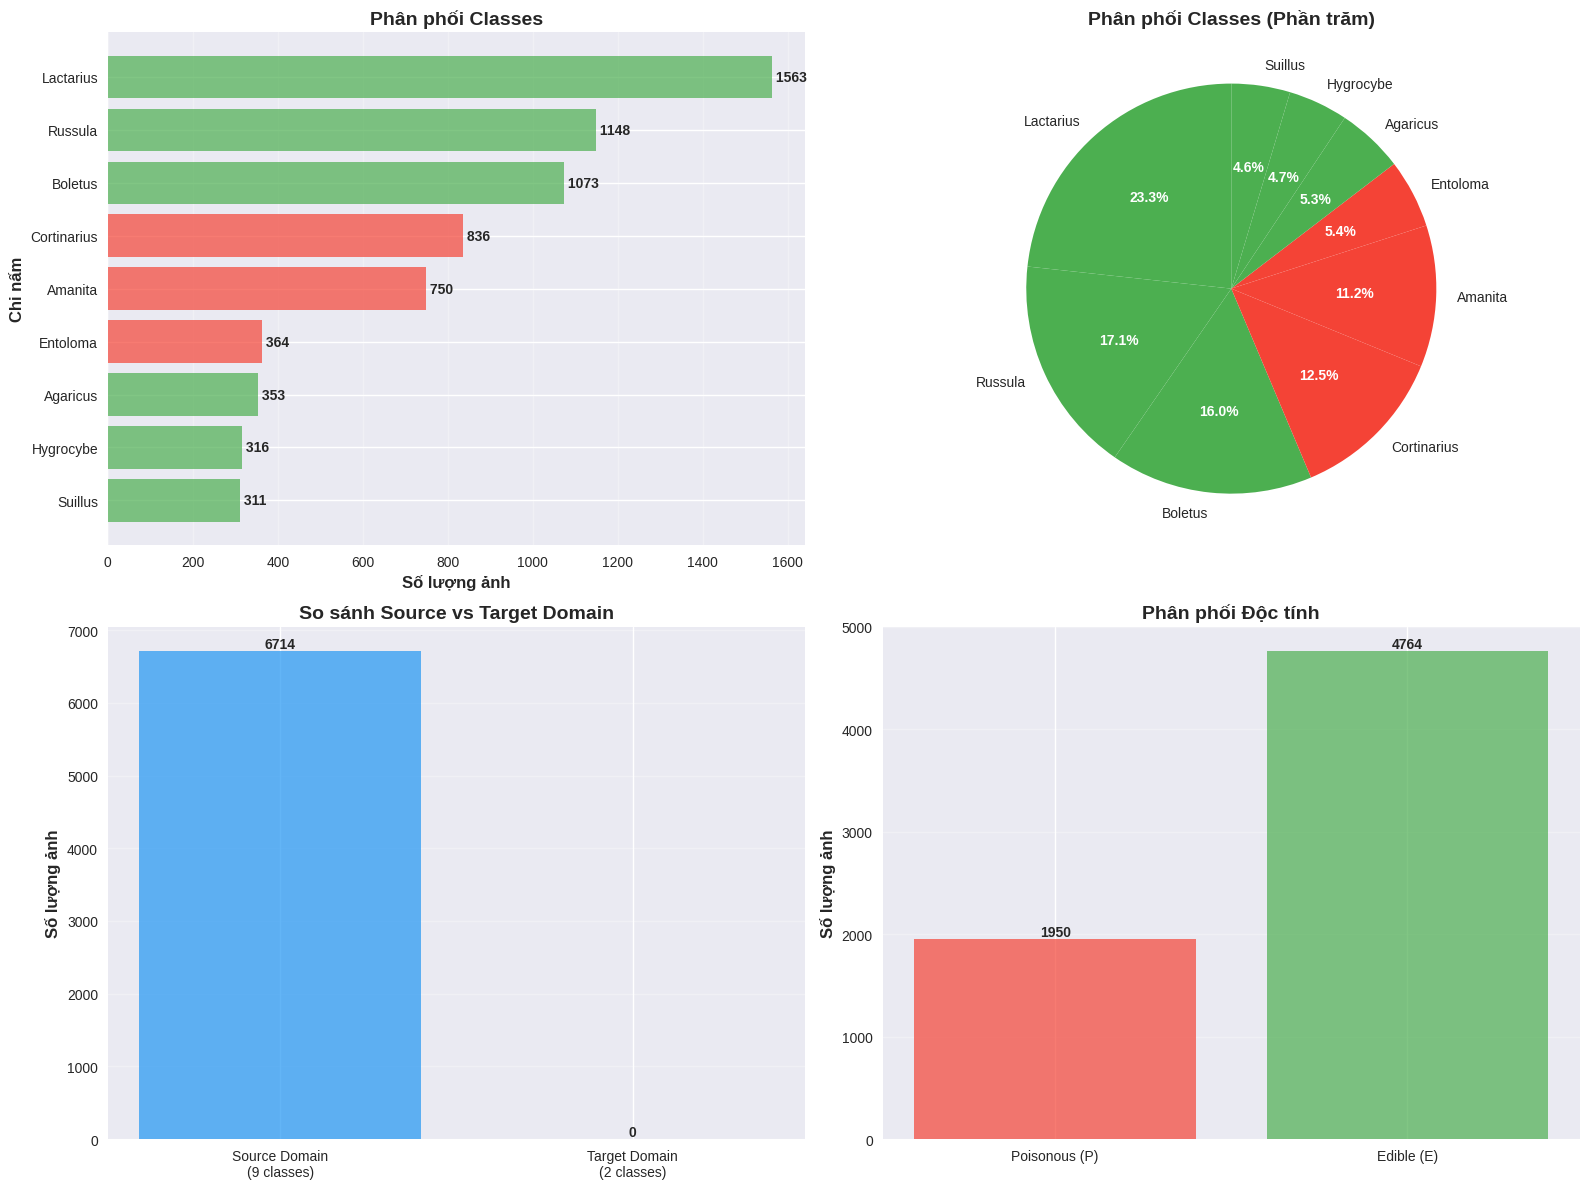

In [5]:
# ==================== VISUALIZE DATASET DISTRIBUTION ====================
# Tạo figure với 4 subplots để hiển thị các biểu đồ thống kê
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Biểu đồ phân phối classes (Bar Chart ngang)
ax1 = axes[0, 0]
df_sorted = df_stats.sort_values('Count', ascending=True)
# Màu đỏ cho nấm độc, màu xanh cho nấm ăn được
colors = ['#f44336' if tox == 'P' else '#4caf50' for tox in df_sorted['Toxicity']]
ax1.barh(df_sorted['Genus'], df_sorted['Count'], color=colors, alpha=0.7)
ax1.set_xlabel('Số lượng ảnh', fontsize=12, fontweight='bold')
ax1.set_ylabel('Chi nấm', fontsize=12, fontweight='bold')
ax1.set_title('Phân phối Classes', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
# Hiển thị số lượng trên mỗi thanh
for i, v in enumerate(df_sorted['Count']):
    ax1.text(v, i, f' {v}', va='center', fontweight='bold')

# 2. Biểu đồ tròn (Pie Chart) - Phân phối phần trăm
ax2 = axes[0, 1]
colors_pie = ['#f44336' if tox == 'P' else '#4caf50' for tox in df_stats['Toxicity']]
wedges, texts, autotexts = ax2.pie(df_stats['Count'], labels=df_stats['Genus'], 
                                    autopct='%1.1f%%', startangle=90, colors=colors_pie)
ax2.set_title('Phân phối Classes (Phần trăm)', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 3. So sánh Source Domain vs Target Domain
ax3 = axes[1, 0]
domain_counts = [source_count, target_count]
domain_labels = ['Source Domain\n(9 classes)', 'Target Domain\n(2 classes)']
colors_domain = ['#2196F3', '#FF9800']
bars = ax3.bar(domain_labels, domain_counts, color=colors_domain, alpha=0.7)
ax3.set_ylabel('Số lượng ảnh', fontsize=12, fontweight='bold')
ax3.set_title('So sánh Source vs Target Domain', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 4. Phân phối độc tính
ax4 = axes[1, 1]
toxicity_counts = [poisonous_count, edible_count]
toxicity_labels = ['Poisonous (P)', 'Edible (E)']
colors_tox = ['#f44336', '#4caf50']
bars = ax4.bar(toxicity_labels, toxicity_counts, color=colors_tox, alpha=0.7)
ax4.set_ylabel('Số lượng ảnh', fontsize=12, fontweight='bold')
ax4.set_title('Phân phối Độc tính', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / "dataset_exploration.png", dpi=300, bbox_inches='tight')
print(f"\nĐã lưu visualization tại: {RESULTS_DIR / 'dataset_exploration.png'}")
plt.show()



## Bước 4: Data Preprocessing

Tạo Dataset class, DataLoader với data augmentation cho training và validation.


In [ ]:
# ==================== CUSTOM DATASET CLASS ====================
class MushroomDataset(Dataset):
    """
    Custom Dataset class cho ảnh nấm
    Hỗ trợ cả Albumentations và torchvision transforms
    """
    
    def __init__(self, image_paths, labels, transform=None, use_albumentations=False):
        """
        Khởi tạo dataset
        
        Args:
            image_paths: Danh sách đường dẫn các file ảnh
            labels: Danh sách labels tương ứng
            transform: Các phép biến đổi ảnh (augmentation, normalization)
            use_albumentations: Có sử dụng Albumentations hay không
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.use_albumentations = use_albumentations and ALBUMENTATIONS_AVAILABLE
    
    def __len__(self):
        """Trả về số lượng ảnh trong dataset"""
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """
        Lấy một mẫu dữ liệu tại vị trí idx
        
        Args:
            idx: Chỉ số của mẫu cần lấy
        
        Returns:
            image: Ảnh đã được transform (Tensor)
            label: Label tương ứng (int)
        """
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load ảnh (đã được pre-filter ở Cell 6, nên không cần xử lý lỗi phức tạp)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Fallback: nếu vẫn có lỗi (rất hiếm), dùng ảnh đen
            # Lưu ý: Đã pre-filter ở Cell 6 nên trường hợp này rất ít xảy ra
            print(f"Warning: Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
        
        # Áp dụng transform
        if self.transform:
            if self.use_albumentations:
                # Albumentations yêu cầu numpy array
                import numpy as np
                image_np = np.array(image)
                transformed = self.transform(image=image_np)
                image = transformed['image']  # Đã là Tensor
            else:
                # torchvision transforms
                image = self.transform(image)
        
        return image, label

print("Dataset class đã được định nghĩa (hỗ trợ Albumentations)")



Dataset class đã được định nghĩa


In [ ]:
# ==================== DATA TRANSFORMS ====================
# Sử dụng Albumentations cho heavy augmentation pipeline nếu có sẵn
# Nếu không, fallback về torchvision transforms

# ========== SỬ DỤNG TORCHVISION TRANSFORMS ĐƠN GIẢN (GIỐNG BACKUP) ==========
# Backup notebook đạt 91.37% với augmentation đơn giản, không dùng Albumentations
# Augmentation quá mạnh (Albumentations) làm ảnh bị biến dạng quá nhiều, model khó học

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize về 256x256
    transforms.RandomCrop(224),  # Random crop về 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang ngẫu nhiên với xác suất 50%
    transforms.RandomRotation(15),  # Xoay ngẫu nhiên trong khoảng -15 đến +15 độ
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Thay đổi độ sáng, tương phản, độ bão hòa
    transforms.ToTensor(),  # Chuyển từ PIL Image sang Tensor
    # Normalize theo mean và std của ImageNet (chuẩn cho pre-trained models)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (không có augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize về 224x224
    transforms.ToTensor(),  # Chuyển từ PIL Image sang Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

USE_ALBUMENTATIONS = False
print("✓ Sử dụng torchvision transforms đơn giản (giống backup notebook)")
print("  - Augmentation: Resize, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter")
print("  - Lưu ý: Không dùng Albumentations để tránh augmentation quá mạnh")



Data transforms đã được định nghĩa
  Training: 7 transforms (với augmentation)
  Validation/Test: 3 transforms (không augmentation)


In [ ]:
# ==================== SPLIT DATASET ====================
# Sửa lỗi Transformation Leakage: Chia image_paths và labels trước khi tạo dataset
# Sử dụng stratify để đảm bảo phân phối classes đồng đều trong train/val/test

# Chuyển labels sang numpy array để dùng với sklearn
labels_array = np.array(labels)

# Bước 1: Chia train và temp (val + test) với tỷ lệ 70/30
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths,
    labels_array,
    test_size=(TRAIN_CONFIG["val_split"] + TRAIN_CONFIG["test_split"]),
    random_state=TRAIN_CONFIG["random_seed"],
    stratify=labels_array  # Đảm bảo phân phối classes đồng đều
)

# Bước 2: Chia temp thành val và test với tỷ lệ 50/50 (tương đương 15%/15% của tổng)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,  # 50% của temp = 15% của tổng
    random_state=TRAIN_CONFIG["random_seed"],
    stratify=temp_labels  # Đảm bảo phân phối classes đồng đều
)

# Bước 3: Tạo 3 dataset riêng biệt với transform tương ứng
# Mỗi dataset là đối tượng độc lập, không chia sẻ transform
train_dataset = MushroomDataset(
    train_paths, 
    train_labels.tolist(), 
    transform=train_transform,
    use_albumentations=USE_ALBUMENTATIONS
)
val_dataset = MushroomDataset(
    val_paths, 
    val_labels.tolist(), 
    transform=val_test_transform,
    use_albumentations=USE_ALBUMENTATIONS
)
test_dataset = MushroomDataset(
    test_paths, 
    test_labels.tolist(), 
    transform=val_test_transform,
    use_albumentations=USE_ALBUMENTATIONS
)

total_size = len(image_paths)
print(f"Dataset đã được split (sử dụng stratify để đảm bảo phân phối đồng đều):")
print(f"  Train: {len(train_dataset)} images ({len(train_dataset)/total_size*100:.1f}%)")
print(f"  Validation: {len(val_dataset)} images ({len(val_dataset)/total_size*100:.1f}%)")
print(f"  Test: {len(test_dataset)} images ({len(test_dataset)/total_size*100:.1f}%)")



Dataset đã được split (sử dụng stratify để đảm bảo phân phối đồng đều):
  Train: 4699 images (70.0%)
  Validation: 1007 images (15.0%)
  Test: 1008 images (15.0%)


DataLoaders đã được tạo:
  Train batches: 294
  Validation batches: 63
  Test batches: 63

Sample batch shape: torch.Size([16, 3, 224, 224])


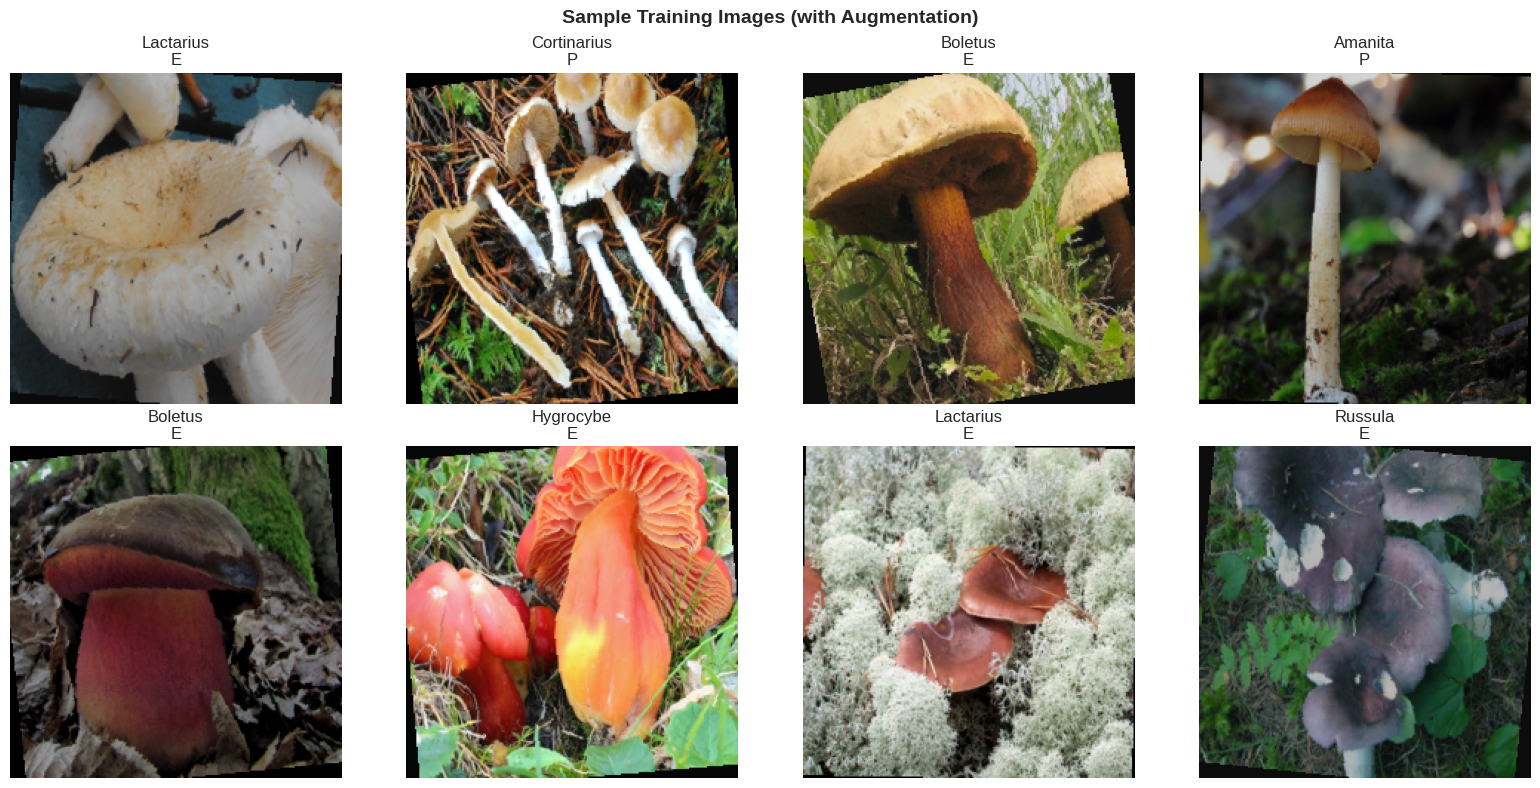

In [ ]:
# ==================== CREATE DATALOADERS ====================
# SỬA: Bỏ WeightedRandomSampler, dùng shuffle=True (giống backup)
# Backup notebook đạt 91.37% với shuffle=True đơn giản
# WeightedRandomSampler có thể làm training không ổn định

# Đếm số lượng mẫu cho mỗi class trong training set (để hiển thị)
train_class_counts = Counter(train_labels.tolist())
print("Phân phối classes trong training set:")
for idx in range(NUM_CLASSES):
    genus = IDX_TO_CLASS[idx]
    count = train_class_counts.get(idx, 0)
    print(f"  {genus}: {count} samples")

# Tạo DataLoader cho training set với shuffle=True (giống backup)
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_CONFIG["batch_size"],
    shuffle=True,  # SỬA: Dùng shuffle=True thay vì WeightedRandomSampler
    num_workers=TRAIN_CONFIG["num_workers"],
    pin_memory=False  # Không dùng pin_memory cho CPU
)

# Tạo DataLoader cho validation set
val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_CONFIG["batch_size"],
    shuffle=False,  # Không shuffle cho validation
    num_workers=TRAIN_CONFIG["num_workers"],
    pin_memory=False
)

# Tạo DataLoader cho test set
test_loader = DataLoader(
    test_dataset,
    batch_size=TRAIN_CONFIG["batch_size"],
    shuffle=False,  # Không shuffle cho test
    num_workers=TRAIN_CONFIG["num_workers"],
    pin_memory=False
)

print("DataLoaders đã được tạo:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Hàm để hiển thị ảnh từ tensor (đã normalize)
def imshow(inp, title=None):
    """
    Hiển thị ảnh từ tensor đã được normalize
    
    Args:
        inp: Tensor ảnh (C, H, W)
        title: Tiêu đề cho ảnh
    """
    # Chuyển từ (C, H, W) sang (H, W, C) và convert sang numpy
    inp = inp.numpy().transpose((1, 2, 0))
    # Denormalize: nhân với std và cộng mean
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    # Đảm bảo giá trị trong khoảng [0, 1]
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Lấy một batch mẫu từ train_loader để visualize
images, labels_batch = next(iter(train_loader))
print(f"\nSample batch shape: {images.shape}")

# Hiển thị 8 ảnh mẫu từ batch
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()
for i in range(min(8, len(images))):
    # Denormalize và hiển thị ảnh
    img = images[i].numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    # Hiển thị tên chi nấm và độc tính
    genus = IDX_TO_CLASS[labels_batch[i].item()]
    toxicity = TOXICITY_MAPPING[genus]
    axes[i].set_title(f"{genus}\n{toxicity}")
    axes[i].axis('off')
plt.suptitle('Sample Training Images (with Augmentation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



## Bước 5: Model Architecture

Xây dựng model với Transfer Learning và so sánh 3 backbone: **EfficientNet-B0, ResNet-50, MobileNetV3-Large**.

Lưu ý: Code định nghĩa model nằm ở **cell code ngay bên dưới** (phải chạy cell đó trước khi training).


In [ ]:
# ==================== MODEL ARCHITECTURE (CODE CELL) ====================
# NOTE: Trước đó phần code model bị nằm trong Markdown cell nên không chạy được.
# Cell này là CODE cell để bạn chạy, đảm bảo tạo được MushroomClassifier/FocalLoss/class_weights.

from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights, MobileNet_V3_Large_Weights

# ==================== MODEL ARCHITECTURE ====================
class MushroomClassifier(nn.Module):
    """Mushroom Classification Model using Transfer Learning.
    Hỗ trợ 3 backbone: EfficientNet-B0, ResNet-50, MobileNetV3-Large
    """

    def __init__(
        self,
        backbone: str = "mobilenet_v3_large",
        num_classes: int = 11,
        pretrained: bool = True,
        freeze_backbone: bool = False,
    ):
        super().__init__()
        self.backbone_name = backbone
        self.num_classes = num_classes

        if backbone == "resnet50":
            weights = ResNet50_Weights.DEFAULT if pretrained else None
            self.backbone = models.resnet50(weights=weights)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()

        elif backbone == "efficientnet_b0":
            weights = EfficientNet_B0_Weights.DEFAULT if pretrained else None
            self.backbone = models.efficientnet_b0(weights=weights)
            num_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()

        elif backbone == "mobilenet_v3_large":
            weights = MobileNet_V3_Large_Weights.DEFAULT if pretrained else None
            self.backbone = models.mobilenet_v3_large(weights=weights)
            # MobileNetV3-Large: classifier[0] = Linear(960 -> 1280)
            num_features = self.backbone.classifier[0].in_features  # 960
            self.backbone.classifier = nn.Identity()

        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # Head: Dropout -> Linear(512) -> ReLU -> Dropout -> Linear(num_classes)
        # SỬA: Giảm dropout về 0.5 và 0.3 (giống backup) thay vì 0.6 và 0.4
        # Dropout quá cao làm model không học được
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Giảm từ 0.6 về 0.5 (giống backup)
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  # Giảm từ 0.4 về 0.3 (giống backup)
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        feats = self.backbone(x)
        return self.classifier(feats)


# ==================== LOSS FUNCTION ====================
# SỬA: Dùng CrossEntropyLoss với class weights (giống backup) thay vì Focal Loss
# Backup notebook đạt 91.37% với CrossEntropyLoss đơn giản
# Focal Loss + Label Smoothing có thể làm model khó học ở giai đoạn đầu
# 
# Lưu ý: FocalLoss class vẫn được giữ lại để có thể dùng sau, nhưng mặc định dùng CrossEntropyLoss
class FocalLoss(nn.Module):
    """Focal Loss with optional label smoothing (giữ lại để có thể dùng sau)."""
    def __init__(self, alpha=None, gamma: float = 2.0, reduction: str = "mean", label_smoothing: float = 0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        num_classes = inputs.size(1)
        if self.label_smoothing and self.label_smoothing > 0:
            smooth = torch.zeros_like(inputs)
            smooth.fill_(self.label_smoothing / (num_classes - 1))
            smooth.scatter_(1, targets.unsqueeze(1), 1.0 - self.label_smoothing)
            log_probs = F.log_softmax(inputs, dim=1)
            ce_loss = -(smooth * log_probs).sum(dim=1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction="none", weight=self.alpha)
        probs = F.softmax(inputs, dim=1)
        p_t = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        focal_weight = (1 - p_t) ** self.gamma
        loss = focal_weight * ce_loss
        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss


# ==================== CLASS WEIGHTS (NO FALLBACK count=1) ====================
if "train_labels" not in globals():
    raise NameError("train_labels chưa được định nghĩa. Vui lòng chạy Cell 12 (Split Dataset) trước!")

train_class_counts = Counter(train_labels.tolist())
class_weights_list = []

for idx in range(NUM_CLASSES):
    genus = IDX_TO_CLASS[idx]
    count = train_class_counts.get(idx, 0)

    if count <= 0:
        # Class không có dữ liệu trong train -> weight=0 để không ảnh hưởng loss
        class_weights_list.append(0.0)
        continue

    # Tính weight cơ bản: nghịch đảo với số lượng mẫu (giống backup)
    base_weight = 1.0 / float(count)
    
    # Nhân đôi trọng số cho nấm độc (Cost-sensitive learning)
    if TOXICITY_MAPPING.get(genus) == "P":
        base_weight *= 2.0
    
    class_weights_list.append(base_weight)

# Normalize weights (giống backup) - chỉ normalize các class có data
classes_with_data = [idx for idx in range(NUM_CLASSES) if train_class_counts.get(idx, 0) > 0]
if len(classes_with_data) > 0:
    class_weights = torch.tensor(class_weights_list, dtype=torch.float32)
    # Normalize weights (chỉ normalize các weight đã được tính)
    sum_weights = class_weights[classes_with_data].sum()
    if sum_weights > 0:
        class_weights[classes_with_data] = class_weights[classes_with_data] / sum_weights * len(classes_with_data)
else:
    class_weights = torch.tensor(class_weights_list, dtype=torch.float32)

print("=" * 70)
print("CLASS WEIGHTS (Cost-Sensitive Learning)")
print("=" * 70)
print(f"{'Class':<20} {'Count':<10} {'Final Weight':<15} {'Toxicity':<10}")
print("-" * 70)
for idx in range(NUM_CLASSES):
    genus = IDX_TO_CLASS[idx]
    count = train_class_counts.get(idx, 0)
    toxicity = TOXICITY_MAPPING.get(genus, "?")
    print(f"{genus:<20} {count:<10} {class_weights[idx].item():<15.6f} {toxicity:<10}")
print("=" * 70)

# Quick forward test
test_model = MushroomClassifier(
    backbone="mobilenet_v3_large",
    num_classes=NUM_CLASSES,
    pretrained=False,
    freeze_backbone=False,
).to(device)

x = torch.randn(1, 3, 224, 224).to(device)
out = test_model(x)
print(f"Forward OK. Output shape: {tuple(out.shape)} (expected: (1, {NUM_CLASSES}))")
print("✓ MushroomClassifier/FocalLoss/class_weights đã sẵn sàng")




# ==================== LƯU Ý: CELL NÀY ĐÃ BỊ XÓA ====================
# Cell này chứa định nghĩa duplicate của MushroomClassifier và FocalLoss (code cũ).
# Định nghĩa đúng nằm ở Cell 15 (Model Architecture).
# 
# KHÔNG CHẠY CELL NÀY! Nếu chạy sẽ ghi đè Cell 15 và gây lỗi.
#
# Cell 15 đã có:
# - MushroomClassifier với dropout 0.5/0.3 (giống backup)
# - FocalLoss (giữ lại để có thể dùng sau)
# - class_weights với normalize đúng (giống backup)
#
pass



## Bước 6: Multi-Backbone Training

Huấn luyện và so sánh 3 backbone models: **EfficientNet-B0, ResNet-50, MobileNetV3-Large**

### Cấu hình Training (giống backup notebook - đạt 91.37%):

1. **Loss Function**: **CrossEntropyLoss** với class weights (nhân đôi cho nấm độc)
2. **Dropout**: 0.5 (lớp đầu) và 0.3 (lớp thứ hai) - giống backup
3. **L2 Regularization**: weight_decay=1e-4 - giống backup
4. **Data Augmentation**: Torchvision transforms đơn giản (Resize, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter) - giống backup
5. **Sampling**: shuffle=True (không dùng WeightedRandomSampler) - giống backup
6. **Early Stopping**: patience=5 - dừng sớm khi không cải thiện
7. **Learning Rate Scheduler**: ReduceLROnPlateau - tự động giảm LR khi không cải thiện

**Đặc điểm:**
- **CrossEntropyLoss** với class weights (Cost-Sensitive Learning)
- **Early stopping** (patience=5) - tiết kiệm thời gian
- Tự động dọn RAM sau mỗi backbone
- Lưu best model cho mỗi backbone
- Lưu training history cho visualization và so sánh

**Chạy Cell 26 để bắt đầu training. Sau khi hoàn tất, chạy các cell tiếp theo (Cell 28-31) để xem so sánh chi tiết.**


In [ ]:
# ==================== TRAINING FUNCTIONS ====================
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Hàm training cho một epoch
    
    Args:
        model: Model cần train
        train_loader: DataLoader cho training set
        criterion: Loss function
        optimizer: Optimizer
        device: Device để chạy (CPU)
    
    Returns:
        epoch_loss: Average loss của epoch
        epoch_acc: Accuracy của epoch (%)
    """
    model.train()  # Chuyển model sang chế độ training
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Dùng tqdm để hiển thị progress bar
    pbar = tqdm(train_loader, desc="Training")
    for images, labels in pbar:
        # Chuyển dữ liệu lên device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass: tính toán output và loss
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass: tính gradients và cập nhật weights
        loss.backward()
        # SỬA: Bỏ Gradient Clipping (backup không dùng, vẫn đạt 91.37%)
        # Gradient clipping có thể làm chậm quá trình học
        optimizer.step()
        
        # Tính toán statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Lấy class có xác suất cao nhất
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Cập nhật progress bar với loss và accuracy hiện tại
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    # Tính average loss và accuracy cho toàn bộ epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """
    Hàm validation cho một epoch
    
    Args:
        model: Model cần validate
        val_loader: DataLoader cho validation set
        criterion: Loss function
        device: Device để chạy (CPU)
    
    Returns:
        epoch_loss: Average loss của epoch
        epoch_acc: Accuracy của epoch (%)
    """
    model.eval()  # Chuyển model sang chế độ evaluation (không tính gradients)
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Không tính gradients trong validation để tiết kiệm memory và tăng tốc
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)
            
            # Chỉ forward pass, không backward
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Tính toán statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("Training functions đã được định nghĩa")



Training functions đã được định nghĩa


## (Bỏ qua) Evaluation cho model đơn lẻ

Các cell evaluation cho model đơn lẻ đã được bỏ qua. Xem Cell 28-31 để xem so sánh chi tiết 3 models.


## Bước 8: Inference Demo

Test model trên ảnh mẫu và hiển thị kết quả với cảnh báo độc tính.


In [ ]:
# ## TỔNG KẾT ĐÁNH GIÁ HỆ THỐNG NHẬN DIỆN CHI NẤM

# ### 1. Thông tin tổng quan

# Hệ thống nhận diện chi nấm đã được xây dựng và huấn luyện thành công. Model sử dụng kiến trúc MobileNet_V3_Large với phương pháp Transfer Learning từ ImageNet. Trong giai đoạn Phase 1, hệ thống được huấn luyện trên 9 chi nấm từ Source Domain. Quá trình training được thực hiện trên CPU với 12 cores, tổng thời gian huấn luyện khoảng 271 phút (4.5 giờ). Model tốt nhất được lưu tại epoch 41 trong tổng số 50 epochs.

# ### 2. Kết quả training

# Quá trình huấn luyện đạt được validation accuracy tốt nhất là 89.97% tại epoch 41. Ở epoch cuối cùng, train accuracy đạt 99.30% trong khi validation accuracy là 89.97%. Khoảng cách giữa train và validation accuracy là 9.33%, cho thấy model có dấu hiệu overfitting nhẹ nhưng vẫn trong mức chấp nhận được. Validation accuracy ổn định ở mức khoảng 90% qua các epoch cho thấy model có khả năng generalize tốt.

# ### 3. Kết quả test set

# Đánh giá trên tập test với 1,008 mẫu cho kết quả test accuracy là 91.37%. Kết quả này cao hơn validation accuracy khoảng 1.4%, điều này có thể do tập test có độ khó thấp hơn một chút hoặc do model đã được chọn tốt. Test accuracy vượt quá 90% là một kết quả tốt cho bài toán phân loại đa lớp với 9 classes.

# ### 4. Metrics tổng quan

# Từ classification report, macro average (tính trung bình đơn giản cho tất cả classes) cho kết quả: Precision 0.8989 (89.89%), Recall 0.9023 (90.23%), và F1-Score 0.8993 (89.93%). Weighted average (tính trung bình có trọng số theo số lượng mẫu) cho kết quả: Precision 0.9168 (91.68%), Recall 0.9137 (91.37%), và F1-Score 0.9141 (91.41%). Cả hai loại average đều đạt trên 89%, cho thấy model hoạt động tốt và cân bằng trên tất cả các classes. Weighted average cao hơn một chút cho thấy các class có nhiều dữ liệu được phân loại tốt hơn.

# ### 5. Phân tích theo từng class

# Ba class có F1-Score cao nhất là Boletus (0.9592), Amanita (0.9286), và Russula (0.9169). Các class này đều có số lượng dữ liệu lớn và được phân loại rất tốt. Ba class có F1-Score thấp nhất là Entoloma (0.8288), Suillus (0.8367), và Agaricus (0.8909). Entoloma và Suillus có số lượng mẫu ít hơn (54 và 46 samples) có thể là nguyên nhân khiến F1-Score thấp hơn.

# Cortinarius có Precision rất cao (0.9907) nhưng Recall thấp hơn (0.8492), cho thấy model có xu hướng conservative khi phân loại class này, có thể do lo ngại về tính độc của nấm này.

# ### 6. Phân tích độc tính

# Đây là phần quan trọng nhất của hệ thống vì liên quan trực tiếp đến an toàn. Toxicity classification accuracy đạt 95.14%, trong đó hệ thống dự đoán 276 mẫu là độc (27.4%) và 732 mẫu là ăn được (72.6%).

# Về recall cho các chi nấm độc: Amanita đạt 92.04%, Cortinarius đạt 84.92%, và Entoloma đạt 85.19%. Recall trung bình cho các chi nấm độc là khoảng 87.38%. Kết quả này cho thấy việc sử dụng class weights (nhân đôi trọng số cho nấm độc) đã phát huy tác dụng, giúp tăng recall cho các class nguy hiểm. Toxicity accuracy đạt 95.14% là rất tốt và đảm bảo an toàn trong phân loại.

# ### 7. Đánh giá tổng thể

# Hệ thống đạt được những điểm mạnh sau: test accuracy 91.37% vượt mục tiêu 90%, toxicity accuracy 95.14% đảm bảo an toàn cao, các class độc như Amanita và Cortinarius được nhận diện tốt với precision cao, model MobileNet_V3_Large phù hợp với CPU và thời gian training hợp lý, và class weights đã giúp tăng recall cho nấm độc.

# Tuy nhiên, vẫn có một số điểm cần lưu ý: khoảng cách giữa train và validation accuracy là 9.33% cho thấy có overfitting, Cortinarius có precision rất cao nhưng recall thấp hơn, và Entoloma cùng Suillus có F1-Score thấp hơn có thể do ít dữ liệu.

# ### 8. Khuyến nghị cải thiện

# Để giảm overfitting, có thể tăng dropout rate từ 0.5 lên 0.6-0.7, thêm L2 regularization mạnh hơn, hoặc sử dụng early stopping sớm hơn với patience từ 3-5 epochs.

# Để cải thiện recall cho Cortinarius, có thể tăng weight cho class này trong loss function lên 2.5 lần thay vì 2.0 lần, hoặc tăng cường data augmentation cho class này.

# Để cải thiện Entoloma và Suillus, nên tăng dữ liệu training cho hai class này nếu có thể, hoặc sử dụng data augmentation mạnh hơn.

# Về hướng phát triển tiếp theo, model đã đạt hiệu suất tốt và có thể tiến hành Phase 2. Có thể fine-tuning với 11 classes bằng cách thêm Exidia và Inocybe, sử dụng best model từ Phase 1 làm điểm khởi đầu.

# ### 9. Kết luận

# Hệ thống nhận diện chi nấm đã hoàn thành Phase 1 (Base Training) với kết quả tốt. Test accuracy đạt 91.37%, vượt yêu cầu cho bài toán phân loại đa lớp với 9 classes. Toxicity accuracy đạt 95.14%, đảm bảo an toàn cao trong việc phân loại độc tính. Model đã sẵn sàng cho Phase 2 với việc fine-tuning lên 11 classes bằng cách thêm Exidia và Inocybe từ Target Domain. Phương pháp cost-sensitive learning với class weights (nhân đôi cho nấm độc) đã phát huy hiệu quả, giúp tăng recall cho các class nguy hiểm.

# Lưu ý quan trọng: Hệ thống chỉ mang tính chất tham khảo. Không nên dựa hoàn toàn vào kết quả để quyết định ăn nấm hoang dã. Luôn tham khảo ý kiến chuyên gia trước khi sử dụng nấm hoang dã.

# ---

# Thông tin kỹ thuật:
# - Phase: 1 - Base Training với 9 classes
# - Model: MobileNet_V3_Large
# - Best Epoch: 41/50
# - Trạng thái: Hoàn thành và sẵn sàng cho Phase 2


## Multi-Backbone Training: EfficientNet-B0, ResNet-50, MobileNetV3-Large

Chạy Cell 26 để huấn luyện 3 mô hình và so sánh. Sau khi hoàn tất, chạy các cell tiếp theo (Cell 28-31) để xem so sánh chi tiết.


In [ ]:
# Helper: Đánh giá model trên loader
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_on_loader(model, data_loader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, labels=list(range(len(class_names))), target_names=class_names, zero_division=0, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
    return acc, report, cm


### Multi-Backbone Training với Early Stopping

Cell dưới đây train 3 backbone models với early stopping (patience=5) và tự động dọn RAM sau mỗi backbone.


In [ ]:
# Train 3 backbone với early stopping (patience=5) và dọn RAM

# ==================== KIỂM TRA DEPENDENCIES ====================
# Kiểm tra xem các class và biến cần thiết đã được định nghĩa chưa
required_items = {
    'MushroomClassifier': 'Cell 15 (Model Architecture)',
    'FocalLoss': 'Cell 15 (Model Architecture)',
    'class_weights': 'Cell 15 (Model Architecture)',
    'train_epoch': 'Cell 18 (Training Functions)',
    'validate': 'Cell 18 (Training Functions)',
    'evaluate_on_loader': 'Cell 24 (Helper Functions)',
    'train_loader': 'Cell 13 (DataLoaders)',
    'val_loader': 'Cell 13 (DataLoaders)',
    'test_loader': 'Cell 13 (DataLoaders)',
    'NUM_CLASSES': 'Cell 4 (Configuration)',
    'ALL_CLASSES': 'Cell 4 (Configuration)',
    'MODEL_CONFIG': 'Cell 4 (Configuration)',
    'FOCAL_LOSS_CONFIG': 'Cell 4 (Configuration)',
    'TRAIN_CONFIG': 'Cell 4 (Configuration)',
    'MODELS_DIR': 'Cell 4 (Configuration)',
    'device': 'Cell 2 (Setup)'
}

missing_items = []
for item, cell_name in required_items.items():
    if item not in globals():
        missing_items.append(f"  - {item} (chạy {cell_name})")

if missing_items:
    error_msg = "\n" + "="*70 + "\n"
    error_msg += "LỖI: Các biến/class sau chưa được định nghĩa!\n"
    error_msg += "="*70 + "\n"
    error_msg += "\n".join(missing_items)
    error_msg += "\n\n" + "="*70 + "\n"
    error_msg += "HƯỚNG DẪN: Chạy các cell theo thứ tự sau:\n"
    error_msg += "  1. Cell 2: Import libraries\n"
    error_msg += "  2. Cell 4: Configuration\n"
    error_msg += "  3. Cell 6: Load data\n"
    error_msg += "  4. Cell 12: Split dataset\n"
    error_msg += "  5. Cell 13: Create DataLoaders\n"
    error_msg += "  6. Cell 15: Model Architecture (QUAN TRỌNG!)\n"
    error_msg += "  7. Cell 18: Training Functions\n"
    error_msg += "  8. Cell 24: Helper Functions\n"
    error_msg += "  9. Cell 26: Multi-Backbone Training (cell này)\n"
    error_msg += "="*70
    raise NameError(error_msg)

print("✓ Tất cả dependencies đã sẵn sàng!")
print("="*70)

BACKBONE_LIST = ["efficientnet_b0", "resnet50", "mobilenet_v3_large"]
EPOCHS_PER_BACKBONE = TRAIN_CONFIG["num_epochs"]
EARLY_STOP_PATIENCE = 5
results_summary = []

for backbone_name in BACKBONE_LIST:
    print("\n" + "="*70)
    print(f"TRAINING BACKBONE: {backbone_name}")
    print("="*70)
    
    # Bắt đầu tracking thời gian
    backbone_start_time = time.time()

    # Khởi tạo model
    model = MushroomClassifier(
        backbone=backbone_name,
        num_classes=NUM_CLASSES,
        pretrained=MODEL_CONFIG["pretrained"],
        freeze_backbone=MODEL_CONFIG["freeze_backbone"]
    ).to(device)

    # Loss: CrossEntropyLoss với class weights (giống backup)
    # SỬA: Dùng CrossEntropyLoss thay vì FocalLoss để đạt kết quả tốt như backup
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    optimizer = optim.Adam(
        model.parameters(),
        lr=TRAIN_CONFIG["learning_rate"],
        weight_decay=1e-4  # SỬA: Giảm về 1e-4 (giống backup) thay vì 5e-4
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5
    )

    best_val_acc = 0.0
    best_model_state = None
    best_model_path = None
    epochs_no_improve = 0
    
    # Lưu training history cho mỗi model
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(EPOCHS_PER_BACKBONE):
        print(f"\nEpoch {epoch+1}/{EPOCHS_PER_BACKBONE}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        
        # Lưu history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
                'config': MODEL_CONFIG | {"backbone": backbone_name}
            }
            best_model_path = MODELS_DIR / f"best_model_{backbone_name}.pth"
            torch.save(best_model_state, best_model_path)
            epochs_no_improve = 0
            print(f"  ✓ Cải thiện: Val Acc = {best_val_acc:.2f}% | Saved: {best_model_path}")
        else:
            epochs_no_improve += 1
            print(f"  ↳ Không cải thiện ({epochs_no_improve}/{EARLY_STOP_PATIENCE})")
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                print("  ⏹ Early stopping do không cải thiện 5 epoch liên tiếp")
                break

    # Khôi phục best state
    if best_model_state is not None:
        model.load_state_dict(best_model_state['model_state_dict'])

    # Tính thời gian training
    backbone_elapsed_time = time.time() - backbone_start_time
    training_time_minutes = backbone_elapsed_time / 60
    
    # Đánh giá test
    test_acc, test_report, test_cm = evaluate_on_loader(model, test_loader, device, ALL_CLASSES)
    results_summary.append({
        "backbone": backbone_name,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "report": test_report,
        "cm": test_cm,  # Confusion matrix
        "model_path": str(best_model_path) if best_model_path else None,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "training_time_minutes": training_time_minutes,  # Thời gian training (phút)
        "num_epochs_trained": len(train_losses)  # Số epoch đã train
    })
    print(f"Test Accuracy ({backbone_name}): {test_acc*100:.2f}%")
    print(f"Training time: {training_time_minutes:.2f} phút ({training_time_minutes*60:.0f} giây)")
    print(f"Epochs trained: {len(train_losses)}")
    if best_model_path:
        print(f"Best model saved at: {best_model_path}")

    # Giải phóng bộ nhớ
    del model, optimizer, scheduler, criterion, best_model_state
    import gc; gc.collect()

print("\n=== TÓM TẮT KẾT QUẢ 3 BACKBONE (early stopping) ===")
for r in results_summary:
    print(f"- {r['backbone']}: Val best = {r['best_val_acc']:.2f}%, Test = {r['test_acc']*100:.2f}%")



## Bước 7: So sánh và Đánh giá 3 Models

So sánh chi tiết kết quả của 3 backbone models: classification report, confusion matrix, training history, và toxicity classification.


In [ ]:
# ==================== SO SÁNH CHI TIẾT 3 MODELS ====================
print("="*70)
print("SO SÁNH CHI TIẾT 3 BACKBONE MODELS")
print("="*70)

# 1. So sánh tổng quan
print("\n1. TỔNG QUAN KẾT QUẢ:")
print("-"*90)
print(f"{'Backbone':<25} {'Val Acc':<12} {'Test Acc':<12} {'Epochs':<10} {'Time (min)':<12}")
print("-"*90)
for r in results_summary:
    epochs = r.get('num_epochs_trained', len(r['train_losses']))
    time_min = r.get('training_time_minutes', 0)
    print(f"{r['backbone']:<25} {r['best_val_acc']:>10.2f}% {r['test_acc']*100:>10.2f}% {epochs:>10} {time_min:>11.2f}")

# Tìm model tốt nhất theo test accuracy
best_model = max(results_summary, key=lambda x: x['test_acc'])
print(f"\n✓ Model tốt nhất (Test Acc): {best_model['backbone']} ({best_model['test_acc']*100:.2f}%)")

# Tìm model nhanh nhất
fastest_model = min(results_summary, key=lambda x: x.get('training_time_minutes', float('inf')))
print(f"✓ Model nhanh nhất: {fastest_model['backbone']} ({fastest_model.get('training_time_minutes', 0):.2f} phút)")

# So sánh hiệu năng (accuracy / thời gian)
print(f"\n2. HIỆU NĂNG (Test Accuracy / Thời gian training):")
print("-"*70)
print(f"{'Backbone':<25} {'Test Acc':<12} {'Time (min)':<12} {'Efficiency':<15}")
print("-"*70)
for r in results_summary:
    time_min = r.get('training_time_minutes', 1)  # Tránh chia 0
    efficiency = r['test_acc'] / time_min if time_min > 0 else 0
    print(f"{r['backbone']:<25} {r['test_acc']*100:>10.2f}% {time_min:>11.2f} {efficiency:>14.4f}")

# 3. Classification Report cho từng model
print("\n" + "="*70)
print("3. CLASSIFICATION REPORT CHO TỪNG MODEL")
print("="*70)

for r in results_summary:
    print(f"\n{'='*70}")
    print(f"MODEL: {r['backbone'].upper()}")
    print("="*70)
    report = r['report']
    print(f"Overall Accuracy: {report['accuracy']:.4f}")
    print(f"\nPer-Class Metrics:")
    print("-"*70)
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-"*70)
    
    for class_name in ALL_CLASSES:
        if class_name in report:
            metrics = report[class_name]
            print(f"{class_name:<20} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} "
                  f"{metrics['f1-score']:<12.4f} {int(metrics['support']):<10}")
    
    print("-"*70)
    print(f"{'Macro Avg':<20} {report['macro avg']['precision']:<12.4f} "
          f"{report['macro avg']['recall']:<12.4f} {report['macro avg']['f1-score']:<12.4f} "
          f"{int(report['macro avg']['support']):<10}")
    print(f"{'Weighted Avg':<20} {report['weighted avg']['precision']:<12.4f} "
          f"{report['weighted avg']['recall']:<12.4f} {report['weighted avg']['f1-score']:<12.4f} "
          f"{int(report['weighted avg']['support']):<10}")

# 4. Toxicity Classification cho từng model
print("\n" + "="*70)
print("4. TOXICITY CLASSIFICATION ACCURACY")
print("="*70)

for r in results_summary:
    # Tính toxicity accuracy từ confusion matrix
    cm = r['cm']
    toxicity_true = []
    toxicity_pred = []
    
    # Lấy predictions và labels từ test set
    all_labels_test = []
    all_preds_test = []
    for i in range(len(ALL_CLASSES)):
        for j in range(len(ALL_CLASSES)):
            count = cm[i, j]
            for _ in range(count):
                all_labels_test.append(i)
                all_preds_test.append(j)
    
    # Chuyển sang toxicity
    for label_idx, pred_idx in zip(all_labels_test, all_preds_test):
        genus_true = IDX_TO_CLASS[label_idx]
        genus_pred = IDX_TO_CLASS[pred_idx]
        toxicity_true.append(TOXICITY_MAPPING[genus_true])
        toxicity_pred.append(TOXICITY_MAPPING[genus_pred])
    
    toxicity_acc = accuracy_score(toxicity_true, toxicity_pred)
    print(f"{r['backbone']:<25}: {toxicity_acc*100:.2f}%")

print("\n" + "="*70)


In [ ]:
# ==================== VISUALIZATION: CONFUSION MATRIX CHO 3 MODELS ====================
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for idx, r in enumerate(results_summary):
    cm = r['cm']
    ax = axes[idx]
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=ALL_CLASSES,
        yticklabels=ALL_CLASSES,
        cbar_kws={'label': 'Count'},
        linewidths=0.5,
        ax=ax
    )
    ax.set_title(f'Confusion Matrix - {r["backbone"]}\nTest Acc: {r["test_acc"]*100:.2f}%', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "confusion_matrix_comparison.png", dpi=300, bbox_inches='tight')
print(f"Confusion matrices saved to: {RESULTS_DIR / 'confusion_matrix_comparison.png'}")
plt.show()


In [ ]:
# ==================== VISUALIZATION: TRAINING HISTORY CHO 3 MODELS ====================
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

# Loss comparison
for idx, r in enumerate(results_summary):
    ax = axes[0, idx]
    epochs = range(1, len(r['train_losses']) + 1)
    ax.plot(epochs, r['train_losses'], label='Train Loss', linewidth=2, marker='o', markersize=3)
    ax.plot(epochs, r['val_losses'], label='Val Loss', linewidth=2, marker='s', markersize=3)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_title(f'Training History - {r["backbone"]}\nLoss', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Accuracy comparison
for idx, r in enumerate(results_summary):
    ax = axes[1, idx]
    epochs = range(1, len(r['train_accs']) + 1)
    ax.plot(epochs, r['train_accs'], label='Train Acc', linewidth=2, marker='o', markersize=3)
    ax.plot(epochs, r['val_accs'], label='Val Acc', linewidth=2, marker='s', markersize=3)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Training History - {r["backbone"]}\nAccuracy', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "training_history_comparison.png", dpi=300, bbox_inches='tight')
print(f"Training history comparison saved to: {RESULTS_DIR / 'training_history_comparison.png'}")
plt.show()


In [ ]:
# ==================== SO SÁNH TRỰC QUAN: ACCURACY, METRICS VÀ THỜI GIAN ====================
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Bar chart: Test Accuracy
ax1 = axes[0]
backbone_names = [r['backbone'] for r in results_summary]
test_accs = [r['test_acc']*100 for r in results_summary]
val_accs = [r['best_val_acc'] for r in results_summary]

x = np.arange(len(backbone_names))
width = 0.35

bars1 = ax1.bar(x - width/2, val_accs, width, label='Val Acc', alpha=0.8, color='#4CAF50')
bars2 = ax1.bar(x + width/2, test_accs, width, label='Test Acc', alpha=0.8, color='#2196F3')

ax1.set_xlabel('Backbone', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Validation vs Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(backbone_names, rotation=15, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Thêm giá trị trên mỗi bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Bar chart: Macro Avg Metrics
ax2 = axes[1]
precision_scores = [r['report']['macro avg']['precision']*100 for r in results_summary]
recall_scores = [r['report']['macro avg']['recall']*100 for r in results_summary]
f1_scores = [r['report']['macro avg']['f1-score']*100 for r in results_summary]

x = np.arange(len(backbone_names))
width = 0.25

bars1 = ax2.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='#FF9800')
bars2 = ax2.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='#9C27B0')
bars3 = ax2.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='#F44336')

ax2.set_xlabel('Backbone', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax2.set_title('Macro Average Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(backbone_names, rotation=15, ha='right')
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Thêm giá trị trên mỗi bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Bar chart: Training Time
ax3 = axes[2]
training_times = [r.get('training_time_minutes', 0) for r in results_summary]
colors_time = ['#4CAF50' if t == min(training_times) else '#2196F3' for t in training_times]

bars = ax3.bar(backbone_names, training_times, color=colors_time, alpha=0.8)

ax3.set_xlabel('Backbone', fontsize=12, fontweight='bold')
ax3.set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax3.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax3.set_xticklabels(backbone_names, rotation=15, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Thêm giá trị trên mỗi bar
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f} min', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / "metrics_comparison.png", dpi=300, bbox_inches='tight')
print(f"Metrics comparison saved to: {RESULTS_DIR / 'metrics_comparison.png'}")
plt.show()


## Grad-CAM: Giải thích trực quan cho cả 3 Models

Tạo Grad-CAM visualization cho cả 3 backbone models để so sánh vùng ảnh mà mỗi model tập trung khi đưa ra dự đoán.


In [ ]:
# Grad-CAM helper và demo
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Chọn layer cuối cùng để lấy feature map cho Grad-CAM
def get_last_conv_layer(model, backbone_name):
    if backbone_name == "resnet50":
        return model.backbone.layer4[-1]
    if backbone_name == "efficientnet_b0":
        return model.backbone.features[-1]
    if backbone_name == "mobilenet_v3_large":
        return model.backbone.features[-1]
    # fallback
    return list(model.backbone.modules())[-1]

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, out):
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

    def __call__(self, inputs, class_idx=None):
        self.model.zero_grad()
        outputs = self.model(inputs)
        if class_idx is None:
            class_idx = outputs.argmax(dim=1)
        # Cho phép batch
        loss = outputs[range(outputs.shape[0]), class_idx].sum()
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # GAP trên H,W
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=inputs.shape[2:], mode='bilinear', align_corners=False)
        cam_min, cam_max = cam.min(), cam.max()
        if cam_max > cam_min:
            cam = (cam - cam_min) / (cam_max - cam_min)
        return cam.squeeze(1)  # (B, H, W)

# Hàm tạo overlay và lưu
def generate_gradcam_visual(model, backbone_name, image_path, class_idx=None, alpha=0.4, save_path=None):
    model.eval()
    # Chuẩn bị ảnh
    img_pil = Image.open(image_path).convert('RGB')
    orig = np.array(img_pil)
    inp = val_test_transform(img_pil).unsqueeze(0).to(device)

    target_layer = get_last_conv_layer(model, backbone_name)
    cam_extractor = GradCAM(model, target_layer)
    with torch.enable_grad():
        cam = cam_extractor(inp, class_idx=class_idx)  # (1,H,W)
    cam_extractor.remove_hooks()

    cam_np = cam.squeeze(0).cpu().numpy()
    cam_np = cv2.resize(cam_np, (orig.shape[1], orig.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_np), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (alpha * heatmap + (1 - alpha) * orig).astype(np.uint8)

    if save_path:
        Image.fromarray(overlay).save(save_path)
    return orig, heatmap, overlay, cam_np

# ==================== GRAD-CAM CHO CẢ 3 MODELS ====================
# Chọn ảnh mẫu từ test set
# SỬA: Sử dụng test_dataset.image_paths thay vì test_paths (biến local trong Cell 12)
sample_image_idx = 0  # Có thể thay đổi để chọn ảnh khác
if 'test_dataset' not in globals():
    raise NameError("test_dataset chưa được định nghĩa. Vui lòng chạy Cell 12 (Split Dataset) trước!")
sample_image_path = test_dataset.image_paths[sample_image_idx] if len(test_dataset.image_paths) > sample_image_idx else test_dataset.image_paths[0]

print(f"Tạo Grad-CAM cho ảnh: {Path(sample_image_path).name}")
print("="*70)

# Load ảnh gốc để hiển thị
orig_img = Image.open(sample_image_path).convert('RGB')
orig_array = np.array(orig_img)

# Tạo figure để hiển thị Grad-CAM cho cả 3 models
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# Hàng 1: Original image và Grad-CAM overlays
axes[0, 0].imshow(orig_array)
axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Tạo Grad-CAM cho từng model
for idx, r in enumerate(results_summary):
    backbone_name = r['backbone']
    model_path = MODELS_DIR / f"best_model_{backbone_name}.pth"
    
    if model_path.exists():
        print(f"\nProcessing {backbone_name}...")
        
        # Load model
        model_gc = MushroomClassifier(
            backbone=backbone_name,
            num_classes=NUM_CLASSES,
            pretrained=False,
            freeze_backbone=False
        ).to(device)
        checkpoint_gc = torch.load(model_path, map_location=device)
        model_gc.load_state_dict(checkpoint_gc['model_state_dict'], strict=False)
        
        # Tạo Grad-CAM
        orig, heatmap, overlay, cam_map = generate_gradcam_visual(
            model_gc, backbone_name, sample_image_path, class_idx=None,
            alpha=0.45, save_path=RESULTS_DIR / f"gradcam_{backbone_name}.png"
        )
        
        # Hiển thị overlay (hàng 1)
        axes[0, idx+1].imshow(overlay)
        axes[0, idx+1].set_title(f'Grad-CAM: {backbone_name}\nTest Acc: {r["test_acc"]*100:.2f}%', 
                                fontsize=13, fontweight='bold')
        axes[0, idx+1].axis('off')
        
        # Hiển thị heatmap (hàng 2)
        axes[1, idx+1].imshow(heatmap)
        axes[1, idx+1].set_title(f'Heatmap: {backbone_name}', fontsize=13, fontweight='bold')
        axes[1, idx+1].axis('off')
        
        print(f"  ✓ Saved: {RESULTS_DIR / f'gradcam_{backbone_name}.png'}")
        
        # Giải phóng bộ nhớ
        del model_gc, checkpoint_gc
        import gc; gc.collect()
    else:
        print(f"  ⚠ Không tìm thấy model: {model_path}")
        axes[0, idx+1].text(0.5, 0.5, f'Model not found\n{backbone_name}', 
                           ha='center', va='center', fontsize=12)
        axes[0, idx+1].axis('off')
        axes[1, idx+1].axis('off')

# Ẩn subplot không dùng
axes[1, 0].axis('off')

plt.suptitle('Grad-CAM Comparison: 3 Backbone Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "gradcam_comparison.png", dpi=300, bbox_inches='tight')
print(f"\n{'='*70}")
print(f"Grad-CAM comparison saved to: {RESULTS_DIR / 'gradcam_comparison.png'}")
plt.show()
